In [1]:
import AnalysisFunction as af
import numpy as np
import pandas as pd
import scipy.linalg as linalg
import scipy.integrate as integrate

## Loading Pantheon data and covariance

In [2]:
# Data
global argsortz

snnamei,zsni,mBi,smBi = np.genfromtxt("data/pantheon_full.txt", unpack=True)
snnamei,zsni,mui,smui = np.genfromtxt("data/pantheon_fullSorted.txt", unpack=True)
covsysraw = np.genfromtxt("data/pantheon_sys_full.txt", unpack=True)

nsn = len(snnamei)
argsortz = np.argsort(zsni)

# Covariance
covsyspanth = np.zeros((nsn,nsn))
k = 0
for i in range(nsn):
    for j in range(nsn):
        covsyspanth[i,j] = covsysraw[k]
        k=k+1

covstatpanth = np.diag(smBi**2)
covpanth = covstatpanth + covsyspanth

covpanthsort = np.zeros((nsn,nsn))
for i in range(nsn):
    for j in range(nsn):
        covpanthsort[i,j]=covpanth[argsortz[i],argsortz[j]]

invcovsort = linalg.inv(covpanthsort)

## Loading CC data and covariance

In [3]:
#32 H(z) data
filename = 'data/Hz32Clocks.txt'
zhzi, hzi, shzi = np.genfromtxt(filename, comments='#', usecols=(0,1,2), unpack=True)

ndata = len(zhzi) #number of data

# Covariance Matrix
filename = 'data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments='#', usecols=(0,1,2,3,4), unpack=True)

cov_mat_diag = np.zeros((ndata, ndata), dtype='float64')

for i in range(ndata):
    cov_mat_diag[i,i] = shzi[i]**2

imf_intp = np.interp(zhzi, zmod, imf)/100
spsooo_intp = np.interp(zhzi, zmod, spsooo)/100

cov_mat_imf = np.zeros((ndata, ndata), dtype='float64')
cov_mat_spsooo = np.zeros((ndata, ndata), dtype='float64')

for i in range(ndata):
    for j in range(ndata):
        cov_mat_imf[i,j] = hzi[i] * imf_intp[i] * hzi[j] * imf_intp[j]
        cov_mat_spsooo[i,j] = hzi[i] * spsooo_intp[i] * hzi[j] * spsooo_intp[j]

cov_mat = cov_mat_imf + cov_mat_spsooo + cov_mat_diag
inv_cov = linalg.inv(cov_mat)

## SNe model

In [4]:
#E(z)^2
def Ez2(z,pars):
    if len(pars)==4:
        H0, wm, wl, f = pars
    elif len(pars)==3:
        H0, wm, wl = pars
    return wm*(1+z)**3+(1-wm-wl)*(1+z)**2+wl

#E(z)^(-1)
def Ez_1(z,pars):
    if len(pars)==4:
        H0, wm, wl, f = pars
    elif len(pars)==3:
        H0, wm, wl = pars
    return 1./np.sqrt(wm*(1+z)**3+(1-wm-wl)*(1+z)**2+wl)

def odesys(y, z, pars):
    dydz = Ez_1(z,pars)
    return dydz

def solsys(y0, z, pars):
    return integrate.odeint(odesys, y0, z, args=(pars,), atol=1e-6)

#Distancia comovel de linha-de-visada adimensional (=dc/dH)
def Dcmodel(z,pars):
    y0 = 0.
    z = np.append([0.],z)
    sol = solsys(y0, z, pars)[:,0]
    sol = np.delete(sol,0)
    return sol

#Distancia comovel transversal adimensional (=dm/dH)
def Dmmodel(z,pars):
    if len(pars)==4:
        H0, wm, wl, f = pars
    elif len(pars)==3:
        H0, wm, wl = pars
    wk = 1. - wm - wl
    Dcm = Dcmodel(z,pars)
    if wk < 0:
        return np.sin(np.sqrt(-wk)*Dcm)/np.sqrt(-wk)
    elif wk > 0:
        return np.sinh(np.sqrt(wk)*Dcm)/np.sqrt(wk)
    return Dcm

def Dlmodel(z,pars):
    return (1+z)*Dmmodel(z,pars)

#Distancia comovel transversal in Mpc
def dmmodel(z,pars):
    if len(pars)==4:
        H0, wm, wl, f = pars
    elif len(pars)==3:
        H0, wm, wl = pars
    dH = c/H0
    wk = 1. - wm - wl
    Dcm = Dcmodel(z,pars)
    if wk < 0:
        return dH*np.sin(np.sqrt(-wk)*Dcm)/np.sqrt(-wk)
    elif wk > 0:
        return dH*np.sinh(np.sqrt(wk)*Dcm)/np.sqrt(wk)
    return dH*Dcm

def dlmodel(z,pars):
    return (1+z)*dmmodel(z,pars)

## Prior

In [5]:
def lnprior(theta):
    if len(theta)==4:
        H0, wm, wl, f = theta
        if 0.0 < wm < 3.0 and 50. < H0 < 100. and -1.0 < wl < 3.0 and 0.1 < f < 2.0:
            return 0.0
    elif len(theta)==3:
        H0, wm, wl = theta
        if 0.0 < wm < 3.0 and 50. < H0 < 100. and -1.0 < wl < 3.0:
            return 0.0    #flat prior

    return -np.inf

## SNe statistics

In [6]:
def chi2SN(theta):
    Ez2i = Ez2(zsni,theta)
    if np.any(Ez2i<0):
        return np.inf
    Dlmodi = Dlmodel(zsni,theta)
    if np.any(Dlmodi<=0):
        return np.inf
    mBmod = 5.*np.log10(Dlmodi)
    dmu = mBmod-mui#delta r
    SA  = np.sum(invcovsort)
    Sr  = np.sum(np.dot(dmu.T,invcovsort))
    Srr = np.dot(np.dot(dmu.T,invcovsort),dmu)
    return Srr - Sr**2./SA
    
def lnlikeSN(theta):
    return -0.5*chi2SN(theta)
 
def lnprobSN(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeSN(theta)

## CC statistics

In [7]:
def chi2Hz(theta):
    if len(theta)==4:
        H0, wm, wl, f = theta
    elif len(theta)==3:
        H0, wm, wl = theta
        f = 1
    E2 = wm*(1+zhzi)**3+(1-wm-wl)*(1+zhzi)**2+wl

    if np.any(E2<0):
        return np.inf

    Hzm = H0*np.sqrt(E2)
    dhz = hzi-Hzm
    inv_covCorr = inv_cov/f**2

    return np.dot(np.dot(dhz.T, inv_covCorr), dhz)

#Calculate the likelihood
def lnlikeHz(par):
    if len(par)==4:
        return -0.5*chi2Hz(par) - ndata*np.log(par[3])
    elif len(par)==3:
        return -0.5*chi2Hz(par)

def lnprobHz(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeHz(theta)

## Combined data

In [8]:
def lnprobHzSN(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeSN(theta) + lnlikeHz(theta)

## Parameters configuration

In [9]:
nstep = 4000

# With correction
par_ml  = [69.1929957609451,0.2480895086492853, 0.6862431649000225, 0.8]
parlabels = ["H_0",r"\Omega_m", r"\Omega_\Lambda", 'f']
parlabtex = ["$H_0$",r"$\Omega_m$", r"$\Omega_\Lambda$", '$f$']
parnames = ['H0','wm','wl','f']
prefix = 'Lcdm_HZPanth_Corr'

# Without correction
par_ml1 = [69.1929957609451,0.2480895086492853, 0.6862431649000225]
parlabels1 = ["H_0",r"\Omega_m", r"\Omega_\Lambda"]
parlabtex1 = ["$H_0$",r"$\Omega_m$", r"$\Omega_\Lambda$"]
parnames1 = ['H0','wm','wl']
prefix1 = 'Lcdm_HZPanth_NoCorr'

# Corrected H(z)+Pantheon

In [10]:
result = af.find_bestfit(lnprobHzSN,par_ml,parnames)
print(result,'\n')
par_ml = result["x"]

C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Maximum likelihood result:
H0  =  70.5310207102836
wm  =  0.3491973312760144
wl  =  0.8208206260065197
f  =  0.6777554227798667
chi2min = 1159.0790566537903
tempo total: 1.487 seg
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1159.0790566537903
             x: [ 7.053e+01  3.492e-01  8.208e-01  6.778e-01]
           nit: 172
          nfev: 295
 final_simplex: (array([[ 7.053e+01,  3.492e-01,  8.208e-01,  6.778e-01],
                       [ 7.053e+01,  3.492e-01,  8.208e-01,  6.778e-01],
                       ...,
                       [ 7.053e+01,  3.492e-01,  8.208e-01,  6.778e-01],
                       [ 7.053e+01,  3.492e-01,  8.208e-01,  6.778e-01]],
                      shape=(5, 4)), array([ 1.159e+03,  1.159e+03,  1.159e+03,  1.159e+03,
                        1.159e+03])) 



In [11]:
samplerHzSNCorr = af.run_emcee(par_ml, 100, lnprobHzSN, 2.0, nstep)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [08:51<00:00,  7.53it/s]

Acceptance fraction: [0.58825 0.5865  0.573   0.5935  0.57775 0.5685  0.59    0.58925 0.60475
 0.57475 0.58375 0.59675 0.59025 0.605   0.59075 0.6095  0.59025 0.586
 0.58425 0.60125 0.60025 0.57675 0.58225 0.60125 0.5985  0.6055  0.589
 0.58375 0.5905  0.60175 0.5955  0.599   0.6015  0.5785  0.58    0.597
 0.59825 0.5935  0.6095  0.589   0.5855  0.58875 0.5925  0.6055  0.5825
 0.58275 0.5815  0.58375 0.5895  0.59025 0.60475 0.5835  0.562   0.5895
 0.59325 0.6025  0.6     0.596   0.58525 0.5665  0.5835  0.6015  0.5935
 0.5915  0.5845  0.57425 0.59475 0.58675 0.5865  0.58325 0.59675 0.59075
 0.59225 0.57525 0.59275 0.5875  0.59525 0.59775 0.59825 0.592   0.596
 0.587   0.5995  0.6005  0.58775 0.603   0.59425 0.59825 0.5845  0.587
 0.591   0.61825 0.597   0.60275 0.58625 0.59675 0.58375 0.57775 0.593
 0.585  ]
Minimum acceptance: 0.562
Maximum acceptance: 0.61825


In [12]:
tauHzSNCorr = af.tau(samplerHzSNCorr, nstep)

[42.77100461 42.15818663 41.182931   43.96986352]
90.97139903237661
Convergiu! :)


In [13]:
samplesHzSNCorr = af.burninthin(samplerHzSNCorr, tauHzSNCorr)

(19500, 4)


In [14]:
af.MC_result(samplesHzSNCorr, par_ml, parnames)

MCMC result:
H0 = 70.52934 +2.62633 +5.30977 -2.59641 -5.26986 (median: 70.51373, ml: 70.53102)
wm = 0.34673 +0.04220 +0.08170 -0.04236 -0.08666 (median: 0.34754, ml: 0.34920)
wl = 0.81567 +0.07797 +0.15143 -0.07851 -0.16251 (median: 0.81760, ml: 0.82082)
f = 0.71991 +0.09341 +0.22066 -0.09442 -0.16440 (median: 0.71110, ml: 0.67776)


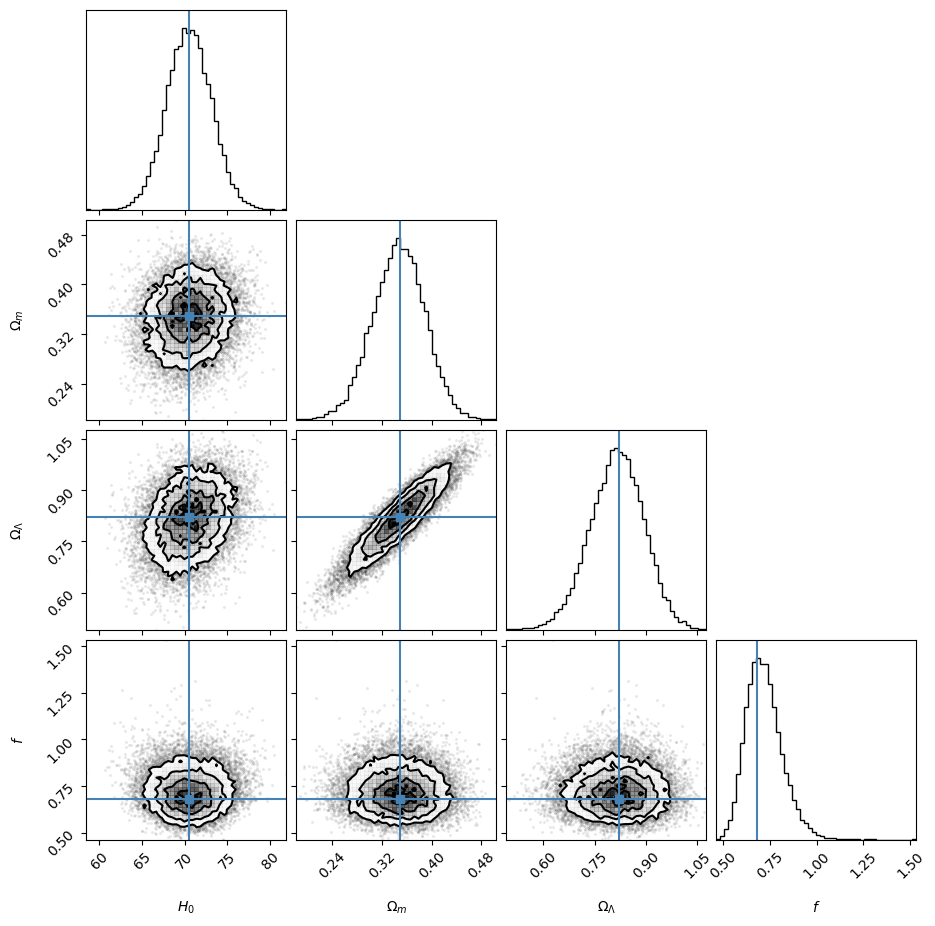

In [15]:
af.plot_cornertriangle(samplesHzSNCorr, parlabtex, par_ml)

In [16]:
af.plotContours([samplesHzSNCorr], parnames, parlabels, ['Corrected H(z)+Pantheon'], save=False, prefix=prefix, fill=False, print_results=True)


KeyboardInterrupt



# Uncorrected H(z)+Pantheon

In [17]:
result = af.find_bestfit(lnprobHzSN,par_ml1,parnames1)
print(result,'\n')
par_ml = result["x"]

Maximum likelihood result:
H0  =  70.62811323945947
wm  =  0.34747497258887766
wl  =  0.8216454980280248
chi2min = 1166.6590907121092
tempo total: 0.687 seg
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1166.6590907121092
             x: [ 7.063e+01  3.475e-01  8.216e-01]
           nit: 98
          nfev: 167
 final_simplex: (array([[ 7.063e+01,  3.475e-01,  8.216e-01],
                       [ 7.063e+01,  3.475e-01,  8.216e-01],
                       [ 7.063e+01,  3.475e-01,  8.216e-01],
                       [ 7.063e+01,  3.475e-01,  8.216e-01]]), array([ 1.167e+03,  1.167e+03,  1.167e+03,  1.167e+03])) 



In [18]:
samplerHzSNUnc = af.run_emcee(par_ml1, 100, lnprobHzSN, 2.0, nstep)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [08:54<00:00,  7.49it/s]

Acceptance fraction: [0.636   0.65125 0.64525 0.66075 0.639   0.6415  0.6375  0.65025 0.6485
 0.641   0.63075 0.6545  0.64725 0.6575  0.64725 0.66125 0.63375 0.63975
 0.63925 0.6475  0.6425  0.631   0.639   0.651   0.64425 0.652   0.64125
 0.64325 0.6425  0.64375 0.64125 0.65375 0.66225 0.65275 0.6375  0.6435
 0.65375 0.6455  0.659   0.64675 0.641   0.6435  0.6495  0.657   0.63675
 0.63475 0.65125 0.63975 0.63925 0.6485  0.66175 0.62975 0.64275 0.64825
 0.65375 0.6455  0.663   0.65175 0.6415  0.63975 0.633   0.6585  0.64325
 0.64275 0.65825 0.64025 0.65625 0.6495  0.64375 0.64725 0.64075 0.65375
 0.653   0.62975 0.65175 0.63825 0.655   0.648   0.6385  0.6545  0.647
 0.634   0.64925 0.6445  0.653   0.6495  0.646   0.63675 0.64375 0.63275
 0.6575  0.6535  0.65675 0.665   0.6465  0.6585  0.62625 0.64925 0.65
 0.6425 ]
Minimum acceptance: 0.62625
Maximum acceptance: 0.665


In [19]:
tauHzSNUnc = af.tau(samplerHzSNUnc, nstep)

[34.79278161 36.87754843 37.03260998]
108.01291084962384
Convergiu! :)


In [20]:
samplesHzSNUnc = af.burninthin(samplerHzSNUnc, tauHzSNUnc)

(23000, 3)


In [21]:
af.MC_result(samplesHzSNUnc, par_ml1, parnames1)

MCMC result:
H0 = 70.57138 +3.49820 +6.97148 -3.49278 -6.93741 (median: 70.55866, ml: 69.19300)
wm = 0.34490 +0.04311 +0.08370 -0.04379 -0.08855 (median: 0.34605, ml: 0.24809)
wl = 0.81654 +0.07964 +0.15491 -0.07980 -0.16431 (median: 0.81795, ml: 0.68624)


In [ ]:
af.plot_cornertriangle(samplesHzSNUnc, parlabtex1, par_ml1)

In [ ]:
af.plotContours([samplesHzSNUnc], parnames1, parlabels1, ['Uncorrected H(z)+Pantheon'], save=False, prefix=prefix, fill=False, print_results=True)

Removed no burn in
Removed no burn in


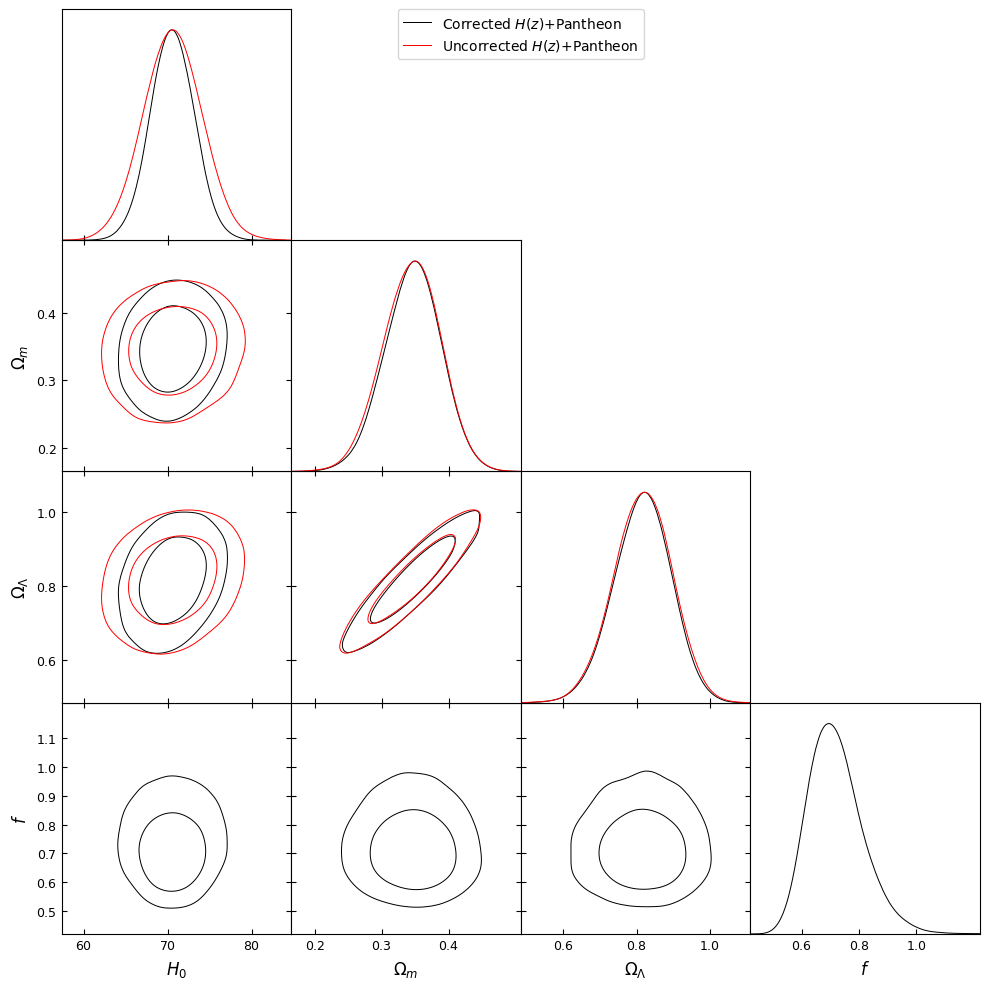

In [22]:
af.plotContours([samplesHzSNCorr, samplesHzSNUnc], [parnames, parnames1], [parlabels, parlabels1],
                legends=['Corrected $H(z)$+Pantheon', 'Uncorrected $H(z)$+Pantheon'], save=True, prefix=prefix, fill=False, size=7)